In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import googlemaps
from datetime import datetime

## import data

In [2]:
raw = pd.read_csv('output.csv')
raw.head()

,Cluster ID,Id,Source,Site name,Address,Zip,Phone,Fax,Program Name,Length of Day,...,Executive Director,Center Director,ECE Available Programs,NAEYC Valid Until,NAEYC Program Id,Email Address,Ounce of Prevention Description,Purple binder service type,Column,Column2
0,0,0,cps_early_childhood_portal_scrape.csv,salvation army - temple / salvation army,1 n ogden ave,NaN,2262649.0,NaN,child care,extended day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,cps_early_childhood_portal_scrape.csv,salvation army - temple / salvation army,1 n ogden ave,NaN,2262649.0,NaN,child care,extended day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,215,cps_early_childhood_portal_scrape.csv,salvation army temple,1 n. ogden,NaN,2262649.0,NaN,community partnerships,"8-11 hours, varies by facility",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,509,cps_early_childhood_portal_scrape.csv,salvation army - temple / salvation army,1 n ogden ave,NaN,2262649.0,NaN,head start,half day/full day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,510,cps_early_childhood_portal_scrape.csv,salvation army - temple / salvation army,1 n ogden ave,NaN,2262649.0,NaN,head start,half day/full day,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print('total number of elements = ', raw.shape[0])
print('number of unique entries = ', raw['Cluster ID'].unique().shape[0])

total number of elements =  2693
number of unique entries =  740


In [4]:
clust = pd.DataFrame(raw.iloc[0])
clust = clust.transpose()

for idx in list(raw['Cluster ID'].unique())[1:]:
    clust = clust.append(raw[raw['Cluster ID'] == idx].iloc[0], ignore_index=True)
    
print(clust.shape)

(740, 33)


## Build Distance Matrix

#### Raw distance:

In [5]:
dist = np.zeros((raw.shape[0], raw.shape[0]))

In [6]:
%%time

for i in range(raw.shape[0]):
    for j in range(raw.shape[0]):
        dist[i][j] = abs(raw['Id'][i] - raw['Id'][j])

CPU times: user 1min 57s, sys: 28 ms, total: 1min 57s
Wall time: 1min 57s


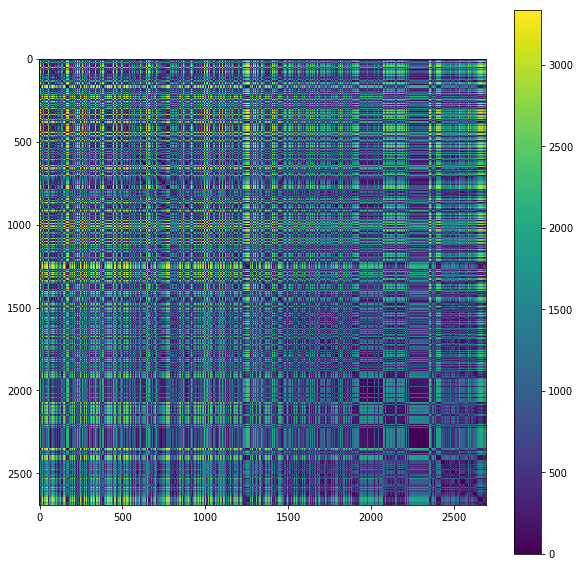

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(dist, cmap='viridis')
plt.colorbar()
plt.show()

#### Cluster Distance

In [8]:
%%time

dist = np.zeros((clust.shape[0], clust.shape[0]))

for i in range(clust.shape[0]):
    for j in range(clust.shape[0]):
        dist[i][j] = abs(clust['Cluster ID'][i] - clust['Cluster ID'][j])

CPU times: user 8.71 s, sys: 0 ns, total: 8.71 s
Wall time: 8.71 s


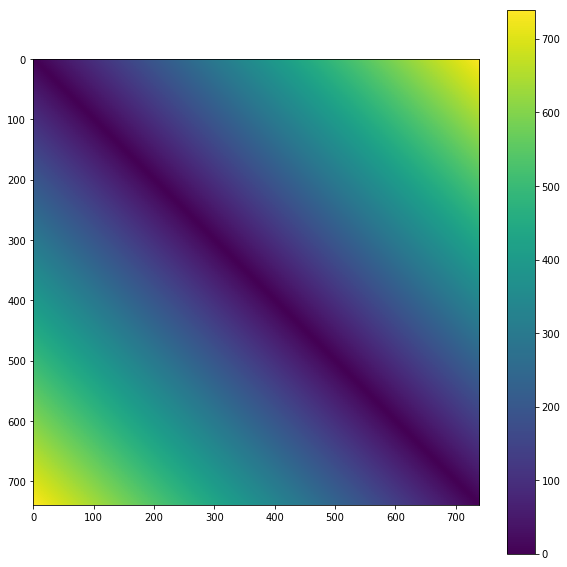

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(dist, cmap='viridis')
plt.colorbar()
plt.show()

In [10]:
print('max = ', np.amax(dist))
print('min = ', np.amin(dist))
print('ave = ', np.mean(dist))
print('std = ', np.std(dist))

max =  739.0
min =  0.0
ave =  246.666216216
std =  174.41983195


## Build Graph

In [11]:
raw_graph = nx.Graph()

In [27]:
%%time
raw_graph.clear()

# add nodes
for i in range(raw.shape[0]):
    raw_graph.add_node(list(raw['Id'])[i], 
                   name=list(raw['Id'])[i], 
                   address=(raw['Address'])[i])
    
# add edges
thresh = 50
for i in range(raw.shape[0]):
    for j in range(raw.shape[0]):
        dist = abs(raw['Id'][i] - raw['Id'][j])
        if dist < thresh:
            raw_graph.add_edge(raw['Id'][i], raw['Id'][j], distance=dist)

CPU times: user 1min 55s, sys: 40 ms, total: 1min 55s
Wall time: 1min 55s


In [13]:
er_graph = nx.Graph()

In [14]:
%%time
er_graph.clear()

# add nodes
for i in range(clust.shape[0]):
    er_graph.add_node(list(clust['Id'])[i], 
                   name=list(clust['Id'])[i], 
                   address=(clust['Address'])[i])
    
# add edges
thresh = 4
for i in range(clust.shape[0]):
    for j in range(clust.shape[0]):
        dist = abs(clust['Cluster ID'][i] - clust['Cluster ID'][j])
        if dist < thresh:
            er_graph.add_edge(clust['Id'][i], clust['Id'][j], distance=dist)

CPU times: user 8.44 s, sys: 0 ns, total: 8.44 s
Wall time: 8.44 s


## Visualize Graphs

#### Raw graph

In [28]:
len(list(raw_graph.nodes))

2693

In [29]:
len(list(raw_graph.edges))

110920

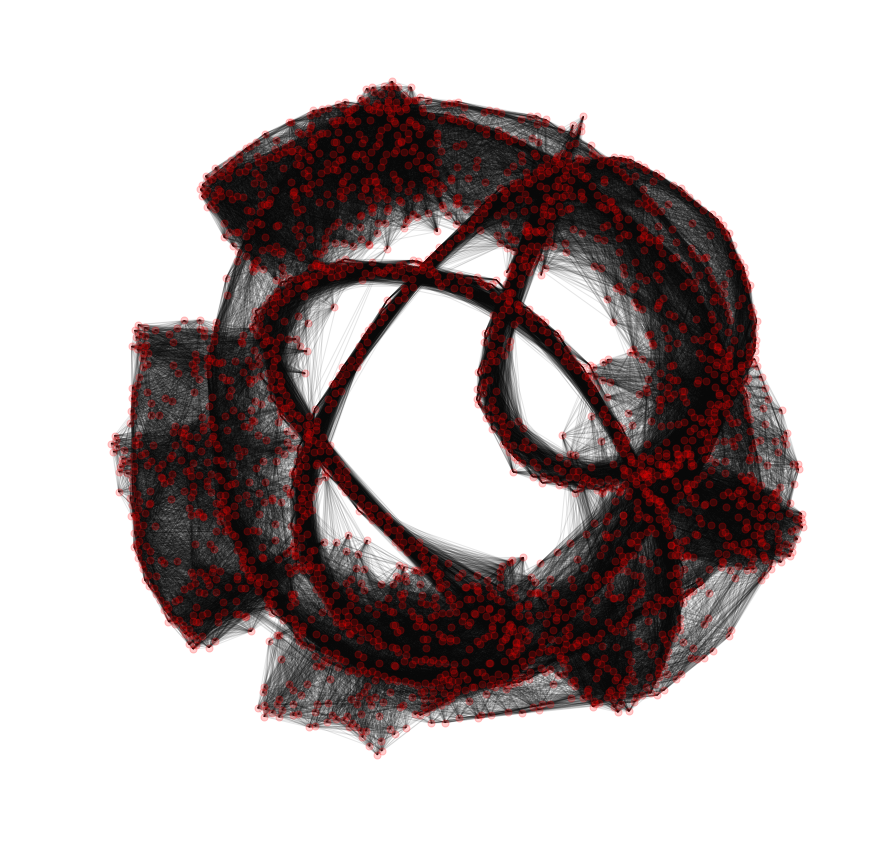

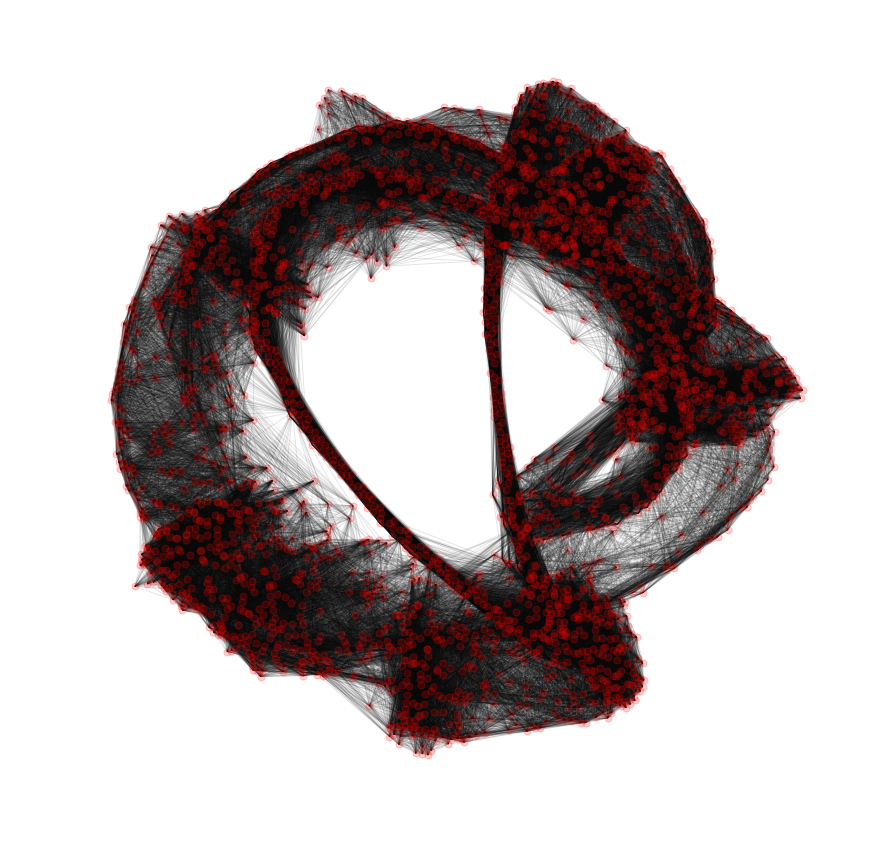

CPU times: user 24.8 s, sys: 8 ms, total: 24.8 s
Wall time: 24.8 s


In [34]:
%%time

plt.figure(figsize=(15,15))
pos = nx.spring_layout(raw_graph, k=0.3)

nc = nx.draw_networkx_nodes(raw_graph, pos, node_size=50, alpha=0.2)
ec = nx.draw_networkx_edges(raw_graph, pos, alpha=0.1)

plt.axis('off')
plt.show()
#plt.savefig('raw_graph.png', dpi=400)

#### Entity resolved graph - without duplicates

In [18]:
alen(list(er_graph.nodes))

740

In [19]:
len(list(er_graph.edges))

2954

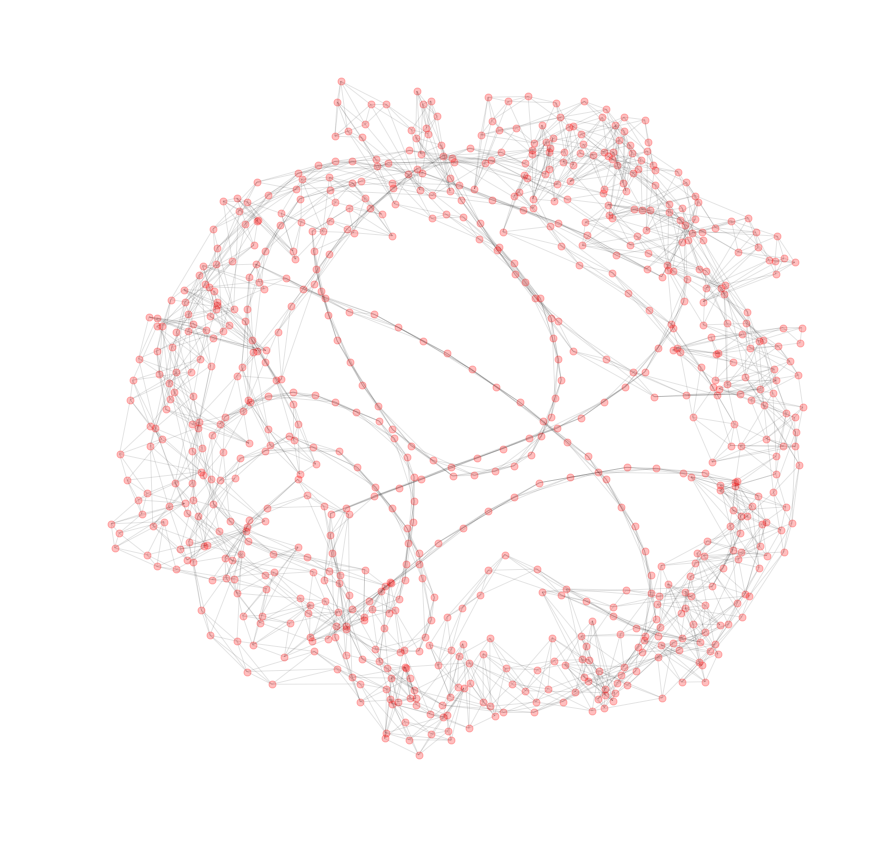

CPU times: user 2.84 s, sys: 0 ns, total: 2.84 s
Wall time: 2.84 s


In [22]:
%%time

plt.figure(figsize=(15,15))
pos = nx.spring_layout(er_graph, k=0.15)

nc = nx.draw_networkx_nodes(er_graph, pos, node_size=50, alpha=0.25)
ec = nx.draw_networkx_edges(er_graph, pos, alpha=.1)

plt.axis('off')
plt.show()
#plt.savefig('er_graph.png', dpi=400)

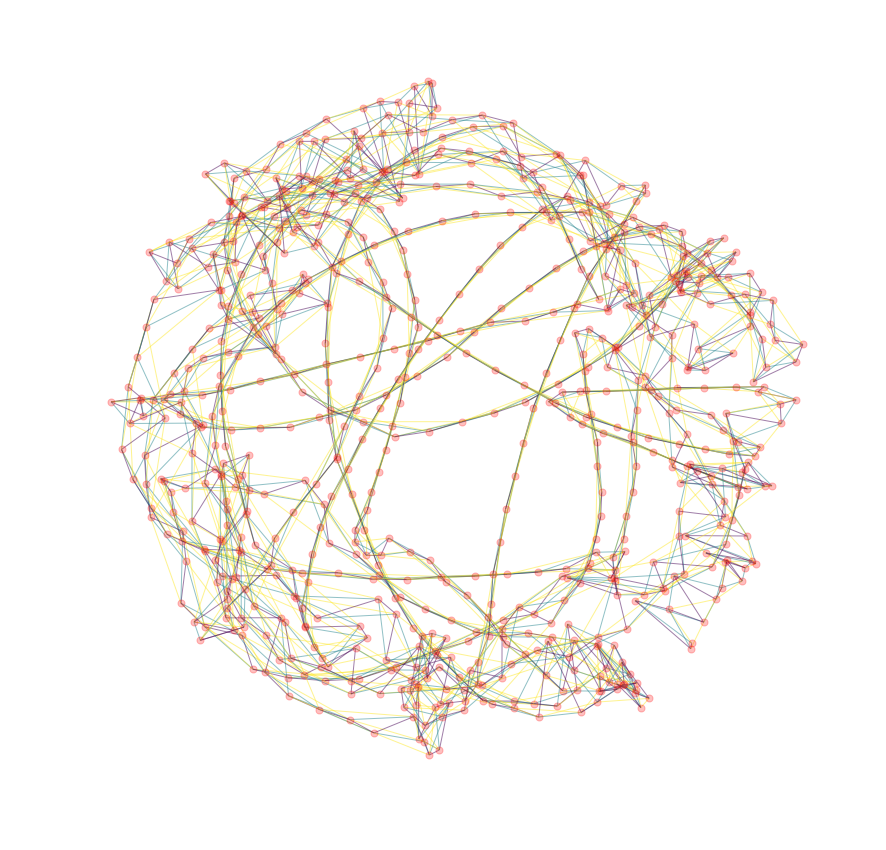

CPU times: user 2.8 s, sys: 4 ms, total: 2.8 s
Wall time: 2.8 s


In [86]:
%%time

distance_list = nx.get_edge_attributes(er_graph, 'distance')
distance_list = list(distance_list.values()) / max(list(distance_list.values()))
distance_list = 255 * distance_list

plt.figure(figsize=(15,15))
pos = nx.spring_layout(er_graph, k=0.15)

nc = nx.draw_networkx_nodes(er_graph, pos, node_size=50, alpha=0.25)
ec = nx.draw_networkx_edges(er_graph, pos, alpha=.5, 
                            edge_color=distance_list, cmap='hot', edge_vmin=100, edge_vmax=255)

plt.axis('off')
plt.show()
#plt.savefig('er_graph_distance.png', dpi=400)